# Calculate NETs and weights 
including the effect of pwv on NET.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
import sys
from  jbolo_funcs import *

In [16]:
!ls yamls

CHLAT_20211210.yaml          SAT_baseline_20220507.yaml
CHLAT_PLR.yaml               SO_S4_comparison
SAT_HF_20211210.yaml         SPLAT_20211210.yaml
SAT_HF_20220216.yaml         SPLAT_20211210_bandfile.yaml
SAT_HWP_20220507.yaml        spt3g.yaml
SAT_LFMF_20211210.yaml       test.yaml
SAT_LFMF_20220216.yaml


# Calculate NET vs pwv, with fixed Psat.

In [23]:
FIXED_PSAT = False

In [24]:
def pwv_vary(yamlfile,site,def_pwv,pwv_vec):
    '''
    open a yaml file that describes an experiment, 
    overload the site and the default pwv, then
    loop through pwv's in pwv_vec saving the NET and Poptical at each.
    
    inputs:  
        yamlfile:  a valid jbolo yaml file
        site: a valid site string
        def_pwv: default pwv, in microns
        pwv_vec: a list or numpy array of pwv's to use, in microns.
        
    outputs:
        out_Popt: a dictionary of vectors of Poptical's
        out_NET:  a dictionary of vectors of NETs
        chlist:  the channel list
    
    '''
    sim = yaml.safe_load(open(yamlfile))
    
    # overload yamls, so we can easily change where a telescope is sited.
    sim['sources']['atmosphere']['site']=site
    sim['sources']['atmosphere']['pwv']=def_pwv  #used to find Psats if not specified, in initial run.

    chlist = list(sim['channels'].keys())
    if FIXED_PSAT:
        if (sim['bolo_config']['psat_method'] != 'specified'):
            run_optics(sim)
            run_bolos(sim)
            sim['bolo_config']['psat_method'] = 'specified'
            for ch in chlist:
                sim['channels'][ch]['psat']=sim['outputs'][ch]['P_sat']
                
    out_NET = {}
    out_Popt = {}
    for ch in chlist:
        out_NET[ch] = np.array([])
        out_Popt[ch]= np.array([])
    
    for pwv in pwv_vec:
        sim['sources']['atmosphere']['pwv'] = pwv
        run_optics(sim)
        run_bolos(sim)
        for ch in chlist:
            out_NET[ch] = np.append(out_NET[ch],sim['outputs'][ch]['NET_NC_total'])
            out_Popt[ch] = np.append(out_Popt[ch],sim['outputs'][ch]['P_opt'])
      
    return(out_Popt, out_NET, chlist)



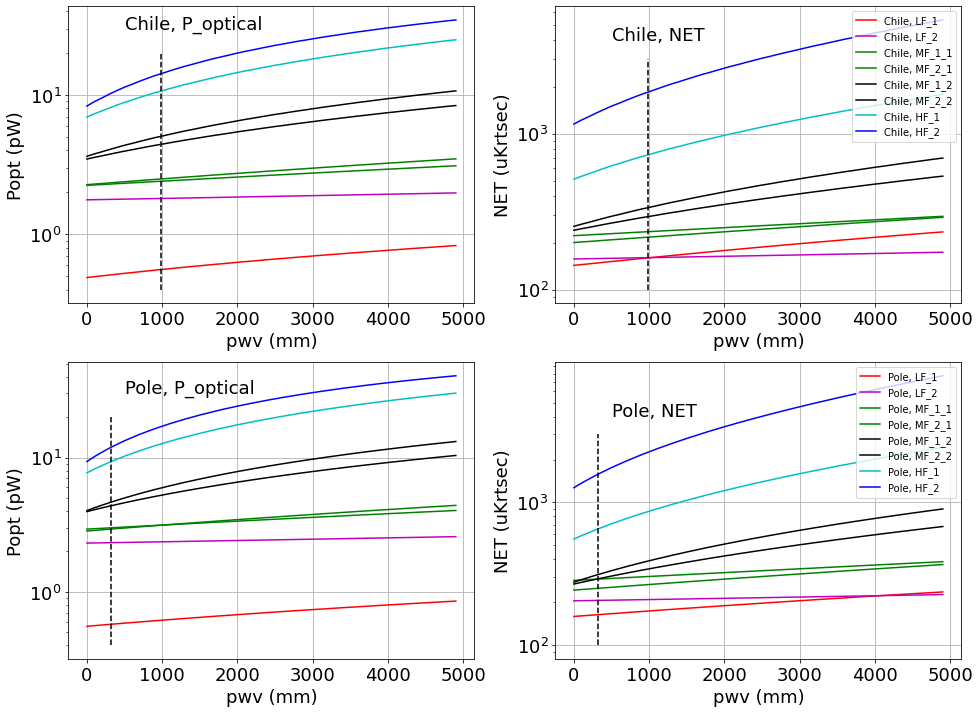

In [52]:
%matplotlib inline
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [16, 12]

yamlfile = 'yamls/SAT_baseline_20220507.yaml'
pwv_vec = np.arange(0,5000,100)

fig, axs = plt.subplots(2,2)

# check whether sim exists, and if it does, clear it so we don't get confused.
if "sim" in locals():
    sim.clear()


Popt_chile, NET_chile, chlist = pwv_vary(yamlfile, 'Atacama',993,pwv_vec)
Popt_pole, NET_pole, chlist = pwv_vary(yamlfile, 'Pole',321,pwv_vec)

chcolor = {'LF_1':'r', 'LF_2':'m', 'MF_1_1':'g', 'MF_2_1':'g', 'MF_1_2':'k', 'MF_2_2':'k', 'HF_1':'c','HF_2':'b'}
for ch in chlist:
    ltype = chcolor[ch]
    labelstr = 'Chile, '+ch
    axs[0][0].semilogy(pwv_vec,Popt_chile[ch]*1e12, ltype,label=labelstr)
    axs[0][1].semilogy(pwv_vec,NET_chile[ch]*1e6, ltype,label=labelstr)
    #ltype = ltype+'--'
    labelstr = 'Pole, '+ch
    axs[1][0].semilogy(pwv_vec,Popt_pole[ch]*1e12,ltype, label=labelstr)
    axs[1][1].semilogy(pwv_vec,NET_pole[ch]*1e6,ltype, label = labelstr)

for ii in [0,1]:
    axs[0][ii].set_xlabel('pwv (mm)')
    axs[1][ii].set_xlabel('pwv (mm)')
    axs[ii][0].set_ylabel('Popt (pW)')
    axs[ii][1].set_ylabel('NET (uKrtsec)')

    axs[ii][1].legend(fontsize=10,loc='upper right')
    for jj in [0,1]:
        axs[ii][jj].grid()


axs[0][0].text(500,30,'Chile, P_optical')
axs[0][0].plot([990,990],[0.4,20],'--k')
axs[0][1].text(500,4000,'Chile, NET')
axs[0][1].plot([990,990],[100,3000],'--k')

axs[1][0].text(500,30,'Pole, P_optical')
axs[1][0].plot([321,321],[0.4,20],'--k')
axs[1][1].text(500,4000,'Pole, NET')
axs[1][1].plot([321,321],[100,3000],'--k')


# pwv histograms

Atacama median pwv: 1.232 mm
Pole median pwv: 0.355 mm


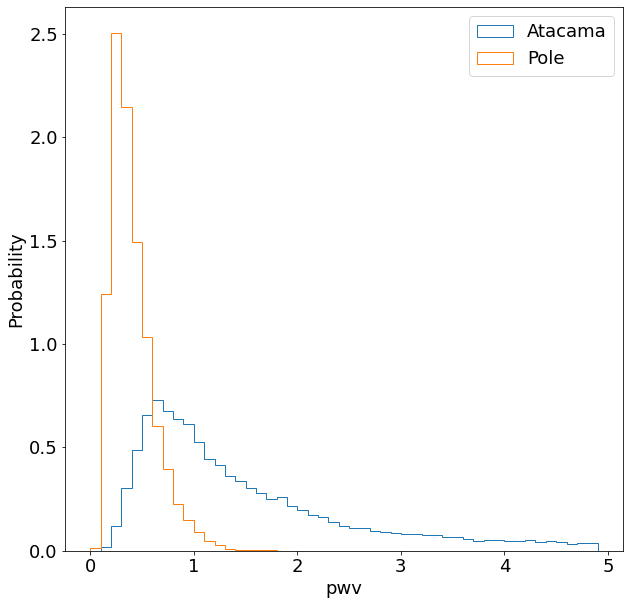

In [91]:
#### Sort the pwv's into a single time-ordered vector and plot histogram;  
# This lets you plot the timestream if desired.
import pickle

pwvs = np.array([])
d = pickle.load(open("atmos/Merra2_atmos_atacama.pck", "rb"))
for ii in np.arange(0,290):
    for month in np.arange(4,12):  # skip jan/feb/march
        for hour in np.arange(0,24):
            pwvs = np.append(pwvs,d[month]['TQV'][hour][ii])
print('Atacama median pwv: {0:5.3f} mm'.format(np.median(pwvs)))

#pwv_bins = np.arange(0,10,0.1) 
pwv_bins = pwv_vec/1000

A_chile = plt.hist(pwvs, bins=pwv_bins, histtype='step',density=True, label='Atacama')

pwvs = np.array([])
d = pickle.load(open("atmos/Merra2_atmos_pole.pck", "rb"))
for ii in np.arange(0,290):
    for month in np.arange(1,10):  # skip december, january
        for hour in np.arange(0,24):
            pwvs = np.append(pwvs,d[month]['TQV'][hour][ii])
print('Pole median pwv: {0:5.3f} mm'.format(np.median(pwvs)))
A_pole = plt.hist(pwvs, bins=pwv_bins, histtype='step',density=True, label='Pole')

plt.xlabel('pwv')
plt.ylabel('Probability')
plt.legend()


LF_1
  Chile weight:  43824572
  Pole  weight:  39412233
  Chile/Pole weight ratio:  1.112
LF_2
  Chile weight:  36274249
  Pole  weight:  23771200
  Chile/Pole weight ratio:  1.526
MF_1_1
  Chile weight:  18211438
  Pole  weight:  12307248
  Chile/Pole weight ratio:  1.480
MF_2_1
  Chile weight:  22320255
  Pole  weight:  16849918
  Chile/Pole weight ratio:  1.325
MF_1_2
  Chile weight:  15524165
  Pole  weight:  13849511
  Chile/Pole weight ratio:  1.121
MF_2_2
  Chile weight:  13836346
  Pole  weight:  13021666
  Chile/Pole weight ratio:  1.063
HF_1
  Chile weight:   2941834
  Pole  weight:   3241442
  Chile/Pole weight ratio:  0.908
HF_2
  Chile weight:    576306
  Pole  weight:    620215
  Chile/Pole weight ratio:  0.929


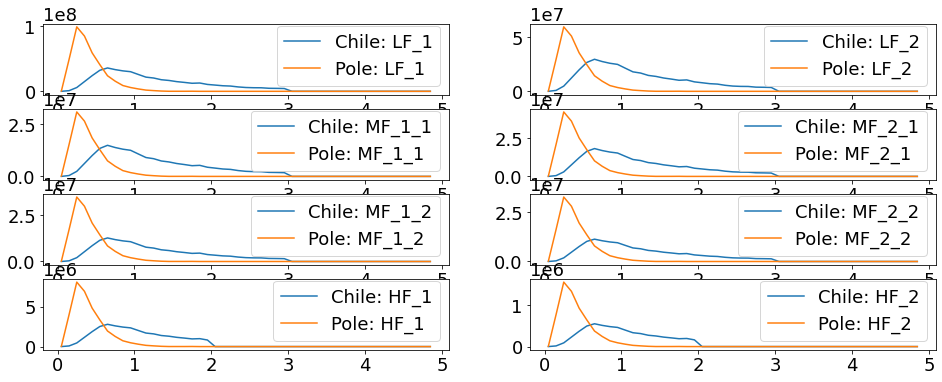

In [92]:
###### Histogram has fewer points than the pwv vector;  its binning vector sets the left side of each bin, and right side of last bin.
# Bin centers are offset by a half a bin.
pwv_bin_centers = (A_chile[1][0:-1]+A_chile[1][1:])/2

# Linearly interpolate NET's to those same bin centers, and calculate weights
w_chile = {}
w_pole = {}
w_ratio = {}
cuts = {'LF_1':3, 
        'LF_2':3, 
        'MF_1_1':3, 
        'MF_2_1':3, 
        'MF_1_2':3, 
        'MF_2_2':3,
        'HF_1':2.0,
        'HF_2':2.0}

for ch in chlist:
    cut_level = cuts[ch]
    
    cut_vector = np.where(pwv_bin_centers<cut_level,1,0)
    
    NET_chile_onbins = np.interp(pwv_bin_centers,pwv_vec, NET_chile[ch])
    NET_pole_onbins =  np.interp(pwv_bin_centers,pwv_vec, NET_pole[ch])
    w_chile[ch] = (A_chile[0]*cut_vector)/NET_chile_onbins**2
    w_pole[ch] =  (A_pole[0]*cut_vector)/NET_pole_onbins**2
    w_chile_tot = np.trapz(w_chile[ch],pwv_bin_centers)
    w_pole_tot = np.trapz(w_pole[ch],pwv_bin_centers)
    w_ratio[ch]=w_chile_tot/w_pole_tot
    print(ch)
    print('  Chile weight: {0:9.0f}'.format(w_chile_tot))
    print('  Pole  weight: {0:9.0f}'.format(w_pole_tot))
    print('  Chile/Pole weight ratio: {0:6.3f}'.format(w_ratio[ch]))

#Make a plot
plt.rcParams['figure.figsize'] = [16, 6]
n_plots = len(chlist)
n_cols = 2
n_rows = int(np.ceil(n_plots/n_cols))

for ii in np.arange(0,n_plots):
    plt.subplot(n_rows,n_cols,ii+1)
    ch = chlist[ii]
    label1 = 'Chile: '+ch
    label2 = 'Pole: '+ch
    plt.plot(pwv_bin_centers,w_chile[ch], label = label1)
    plt.plot(pwv_bin_centers,w_pole[ch], label = label2)
    plt.legend()




# Make a plot of weight vs pwv cut level for each channel, for each site.

['LF_1', 'LF_2', 'MF_1_1', 'MF_2_1', 'MF_1_2', 'MF_2_2', 'HF_1', 'HF_2']


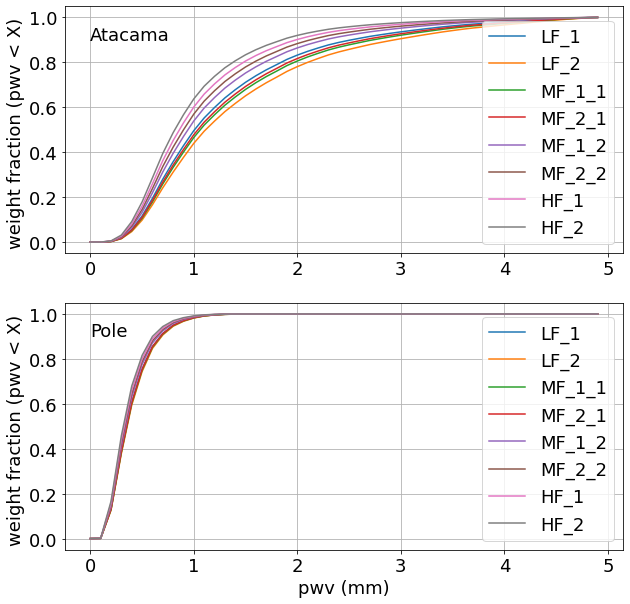

In [93]:
###### Histogram has fewer points than the pwv vector;  its binning vector sets the left side of each bin, and right side of last bin.
# Bin centers are offset by a half a bin.
pwv_bin_centers = (A_chile[1][0:-1]+A_chile[1][1:])/2

# Linearly interpolate NET's to those same bin centers, and calculate weights
w_chile = {}
w_pole = {}

print(chlist)
for ch in chlist:
    w_chile[ch]=np.array([])
    w_pole[ch]=np.array([])
    
cutvec = np.arange(0,5,0.1) # 

for cut in cutvec:
    cut_vector = np.where(pwv_bin_centers<cut,1,0)
    for ch in chlist:
        NET_chile_onbins = np.interp(pwv_bin_centers,pwv_vec/1000., NET_chile[ch])
        NET_pole_onbins =  np.interp(pwv_bin_centers,pwv_vec/1000., NET_pole[ch])
        
        wc = (A_chile[0]*cut_vector)/NET_chile_onbins**2
        w_chile_tot = np.trapz(wc,pwv_bin_centers)
        w_chile[ch] = np.append(w_chile[ch],w_chile_tot)
        
        wp =  (A_pole[0]*cut_vector)/NET_pole_onbins**2
        w_pole_tot = np.trapz(wp,pwv_bin_centers)
        w_pole[ch] = np.append(w_pole[ch],w_pole_tot)
    
plt.rcParams['figure.figsize'] = [10, 10]
plt.clf()
plt.subplot(2,1,1)
for ch in chlist:
    plt.plot(cutvec, w_chile[ch]/np.max(w_chile[ch]),label=ch)
plt.legend()
plt.ylabel('weight fraction (pwv < X) ')
plt.text(0,0.9,'Atacama')
plt.grid()

plt.subplot(2,1,2)
for ch in chlist:
    plt.plot(cutvec, w_pole[ch]/np.max(w_pole[ch]),label=ch)
plt.legend()
plt.xlabel('pwv (mm)')
plt.ylabel('weight fraction (pwv < X) ')
plt.text(0,0.9,'Pole')
plt.grid()



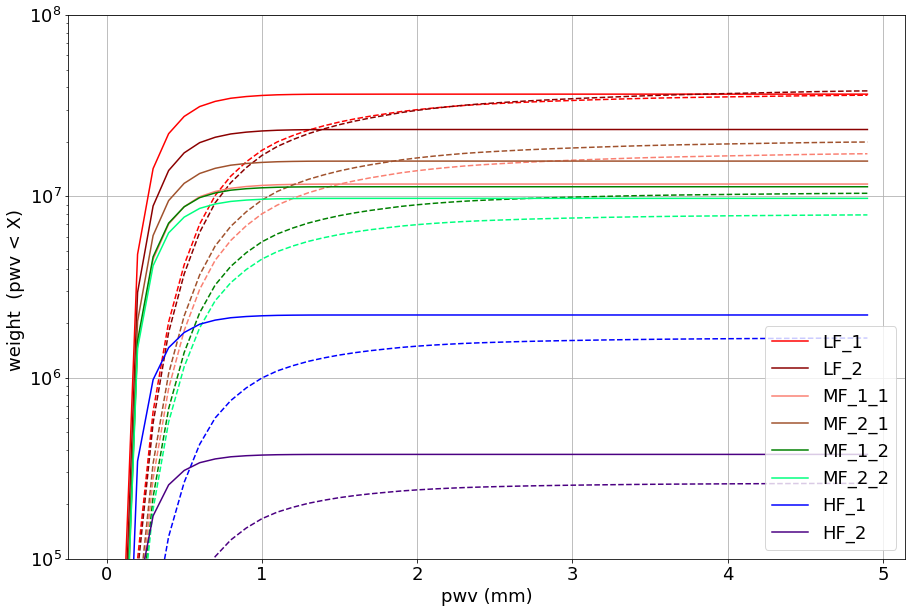

In [114]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.clf()
plt.subplot(2,1,1)
for ch in chlist:
    plt.plot(cutvec, w_chile[ch]/np.max(w_chile[ch]),label=ch)
plt.legend()
plt.ylabel('weight fraction (pwv < X) ')
plt.text(0,0.9,'Atacama')
plt.grid()

plt.clf()
colors = ['r','DarkRed','Salmon','Sienna','g','SpringGreen','b','Indigo']
ii = 0
for ch in chlist:
    plt.semilogy(cutvec, w_pole[ch],color=colors[ii],label=ch)
    plt.semilogy(cutvec, w_chile[ch],'--',color=colors[ii])
    ii += 1
plt.legend()
plt.xlabel('pwv (mm)')
plt.ylabel('weight  (pwv < X) ')
#plt.text(0,0.9,'Pole')
plt.ylim(1e5,1e8)
plt.grid()